In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot

In [2]:
# import tarfile


# fname = 'fer2013.tar.gz'
# if fname.endswith("tar.gz"):
#     tar = tarfile.open(fname, "r:gz")
#     tar.extractall()
#     tar.close()
# elif fname.endswith("tar"):
#     tar = tarfile.open(fname, "r:")
#     tar.extractall()
#     tar.close()
path_to_dataset = 'train'
LABELS = os.listdir(path_to_dataset)

In [3]:
df = pd.read_csv('fer2013.csv')

In [4]:
label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'} 

In [5]:
np.array(df.pixels.loc[0].split(' ')).reshape(48,48)

array([['70', '80', '82', ..., '52', '43', '41'],
       ['65', '61', '58', ..., '56', '52', '44'],
       ['50', '43', '54', ..., '49', '56', '47'],
       ...,
       ['91', '65', '42', ..., '72', '56', '43'],
       ['77', '82', '79', ..., '105', '70', '46'],
       ['77', '72', '84', ..., '106', '109', '82']], dtype='<U3')

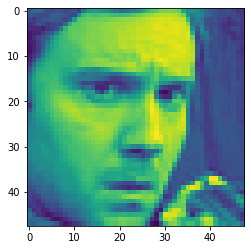

In [6]:
pyplot.imshow(np.array(df.pixels.loc[0].split(' ')).reshape(48,48).astype('float'))

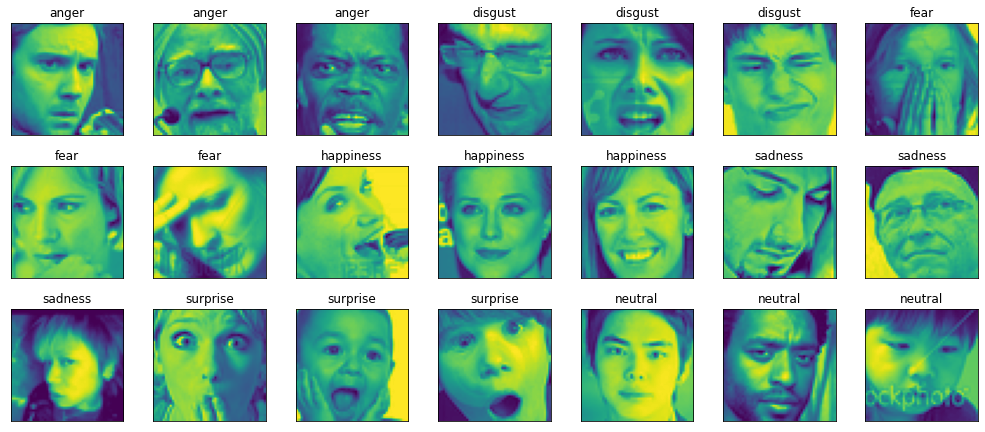

In [7]:
fig = pyplot.figure(1, (14, 14))
k = 0
for label in sorted(df.emotion.unique()):
    for j in range(3):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[label])
        pyplot.tight_layout()

In [8]:
img_array=df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48,48,1).astype('float32'))

In [9]:
img_array=np.stack(img_array,axis=0)

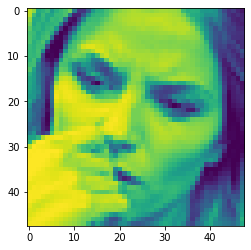

In [10]:
pyplot.imshow(img_array[2])

In [11]:
lables=df.emotion.values

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
xtrain,xtest,ytrain,ytest=train_test_split(img_array,lables,test_size=.2) #hear we are spliting the model 2-0%

In [14]:
xtrain.shape,ytest.shape,xtest.shape,ytest.shape

((28709, 48, 48, 1), (7178,), (7178, 48, 48, 1), (7178,))

In [15]:
xtrain=xtrain/255
# ytrain=ytrain/255
xtest=xtest/255
# ytest=ytest/255


In [16]:
basemodel = tf.keras.models.Sequential([tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape = (48,48,1)),
                                        tf.keras.layers.MaxPool2D(2,2),
                                        #1 layer
                                        tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape = (48,48,1)),
                                        tf.keras.layers.MaxPool2D(2,2),
                                        #2:---
                                        tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
                                        tf.keras.layers.MaxPool2D(2,2),
                                        #3_-----
                                        tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
                                        tf.keras.layers.MaxPool2D(2,2),
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(1000,activation='relu'),
                                        tf.keras.layers.Dense(7,activation = 'softmax')                          
                                        ])

In [17]:
basemodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 256)         2

In [18]:
basemodel.compile(loss ="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [18]:
import os
try:
    os.mkdir('checkpoint')
except:
    pass

In [19]:
file_name = 'best_model.h5'
checkpoint_path= os.path.join('checkpoint',file_name)


call_back = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                 monitor='val_accuracy', 
                                                 verbose=1,
                                                 save_freq='epoch',
                                                 save_best_only=True, #use to do not save the all the moddel
                                                 save_weights_only=False,  #use to complete save the model
                                                 mode='max') #to max the validation

In [21]:
a=basemodel.fit(xtrain,ytrain,epochs=2,validation_split=.1,callbacks=call_back)

Epoch 1/2
808/808 [==============================] - 61s 75ms/step - loss: 1.7484 - accuracy: 0.2827 - val_loss: 1.5774 - val_accuracy: 0.3741

Epoch 00001: val_accuracy improved from -inf to 0.37409, saving model to checkpoint\best_model.h5
Epoch 2/2
808/808 [==============================] - 64s 79ms/step - loss: 1.4547 - accuracy: 0.4330 - val_loss: 1.3780 - val_accuracy: 0.4810

Epoch 00002: val_accuracy improved from 0.37409 to 0.48102, saving model to checkpoint\best_model.h5


In [22]:
score = basemodel.evaluate(xtest,ytest, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

Test Loss: 1.369775652885437
Test accuracy: 0.47492337226867676


In [141]:
# import cv2

# for i in os.listdir('images'):
#     image = cv2.imread('images/' + i, cv2.IMREAD_GRAYSCALE)
#     image = image.reshape(48, 48, 1)
#     prediction = basemodel.predict(np.array([image]))
#     plt.imshow(image, cmap='gray')
#     plt.ylabel("Predicted: {}".format(get_label(prediction)))
#     plt.show()

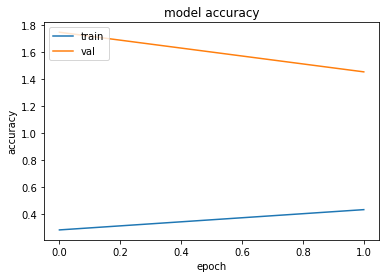

In [28]:
import keras
from matplotlib import pyplot as plt
# history = basemodel.fit(xtrain, ytrain,validation_split = 0.1, epochs=50, batch_size=4)
plt.plot(a.history['accuracy'])
plt.plot(a.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

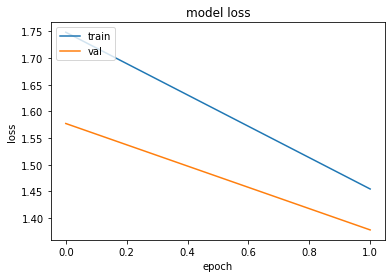

In [24]:
plt.plot(a.history['loss'])
plt.plot(a.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
print(a.history.keys())
#  "Accuracy"
plt.plot(a.history['acc'])
plt.plot(a.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(a.history['loss'])
plt.plot(a.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


KeyError: 'acc'

In [21]:
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt


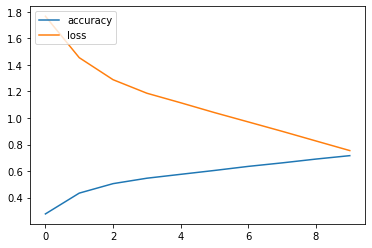

In [145]:
plt.plot(a.history['accuracy'])
plt.plot(a.history['loss'])
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

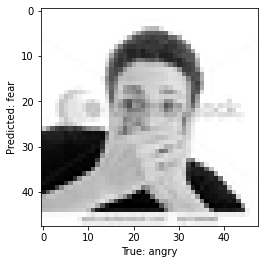

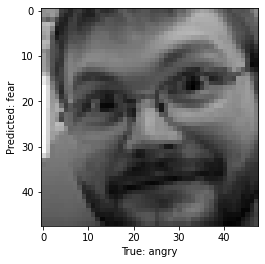

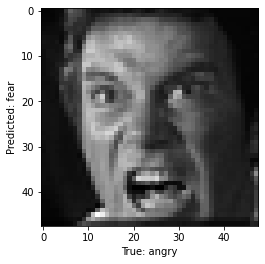

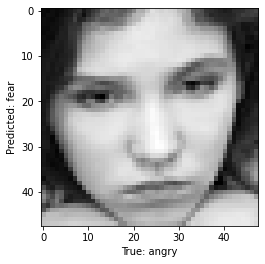

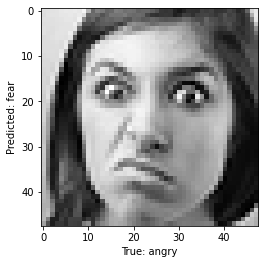

In [22]:
def get_label(k):
    return LABELS[np.argmax(k)]

import random
n = 5
random_indexes = [random.randint(0, xtest.shape[0]) for _ in range(n)]
for i in random_indexes:
    prediction = basemodel.predict(np.array([xtest[i]]))
    plt.imshow(xtest[i], cmap='gray')
    plt.ylabel("Predicted: {}".format(get_label(prediction[0])))
    plt.xlabel("True: {}".format(get_label(ytest[i])))
    plt.show()

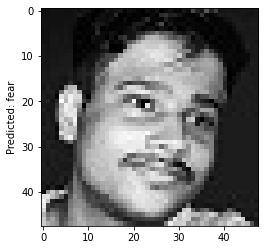

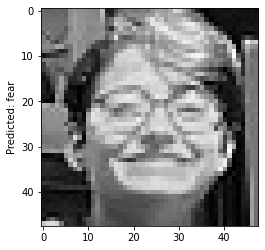

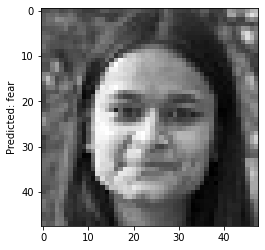

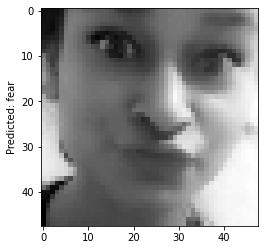

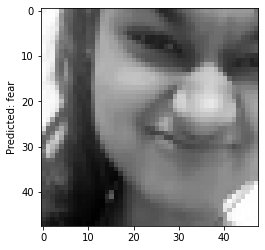

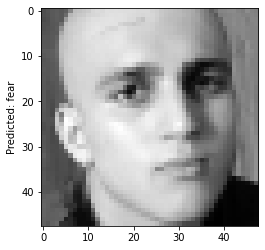

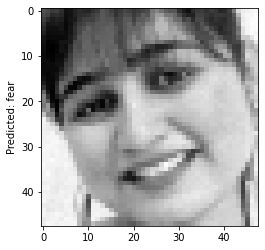

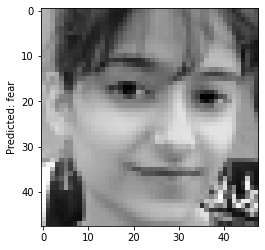

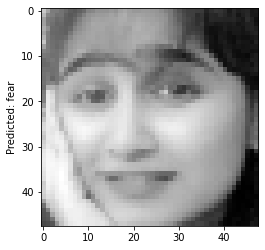

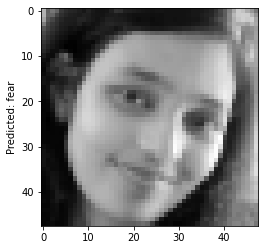

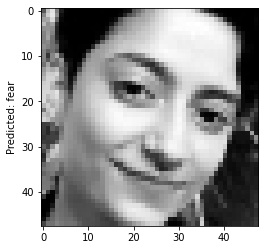

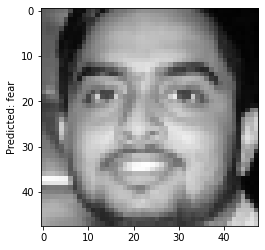

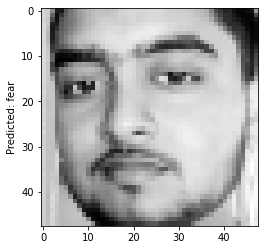

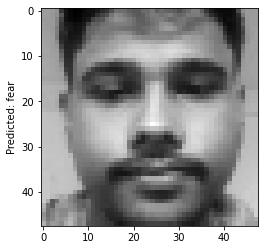

In [23]:
import cv2

for i in os.listdir('images'):
    image = cv2.imread('images/' + i, cv2.IMREAD_GRAYSCALE)
    image = image.reshape(48, 48, 1)
    prediction = basemodel.predict(np.array([image]))
    plt.imshow(image, cmap='gray')
    plt.ylabel("Predicted: {}".format(get_label(prediction)))
    plt.show()
       

Real face emotion surprise
Predicted face recognition by CCN model surprise


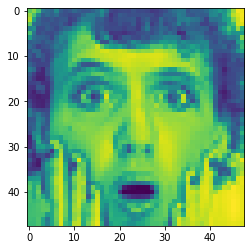

In [24]:
final_model=tf.keras.models.load_model(checkpoint_path)
from IPython.display import clear_output
import time
for k in range (10):
    print(f'Real face emotion {label_to_text[ytest[k]]}')
    predicted_class=final_model.predict(tf.expand_dims(xtest[k],0)).argmax()
    print(f'Predicted face recognition by CCN model {label_to_text[predicted_class]}')
    pyplot.imshow(xtest[k])
    pyplot.show()
    time.sleep(2)
    clear_output(wait=True)